# Assignment: Basic Web Scrapping and more...

**Student : Kishankumar Bhimani**

In [1]:
name = 'Kishankumar Bhimani'
if name == '':
    raise NotImplementedError('Put your name')

You will receive points for:
- implementing the given tasks.
- using good practices such as OOP in some cases, or decorators.
- good code structure on the last task.
- handling edge cases and exceptions.
- comprehensive unit tests (by using any of the libraries seen. I recommend `unittest`).

We will need the following libraries, but of course you can add the libraries you prefer.

In [2]:
for _ in range(2):
    try:
        from bs4 import BeautifulSoup
        import requests
        import unittest
        import networkx as nx
    except ImportError:
        ! pip install beautifulsoup4
        ! pip install requests
        ! pip install unittest2
        ! pip install networkx
    else:
        break

## Task 1

The following function receives a URL, and tries to fetch all the links on it, and returns a list with all those links.

1. Modify the function so that it returns the expected links.

2. Be sure to do unit testing to check that the behaviour of the function is the one we expect.

3. Consider edge cases (for example, what if the given URL is not a valid URL).

In [3]:
def get_all_links(url: str):
    """
    Get all the links in the webpage at the given URL.

    :param url: A string that is the URL of the webpage where we need to find the links
    :return: A list with all the links of the given webpage
    """
    try:
        response = requests.get(url)
        response.raise_for_status()
        soup = BeautifulSoup(response.text, 'html.parser')

        links = [a.get('href') for a in soup.find_all('a', href=True)]
        valid_links = [link for link in links if link.startswith('http')]

        return valid_links
    except requests.exceptions.RequestException as e:
        print(f"Error fetching the URL: {e}")
        return []

In [4]:
get_all_links('http://en.wikipedia.com')[:10]

['https://donate.wikimedia.org/?wmf_source=donate&wmf_medium=sidebar&wmf_campaign=en.wikipedia.org&uselang=en',
 'https://donate.wikimedia.org/?wmf_source=donate&wmf_medium=sidebar&wmf_campaign=en.wikipedia.org&uselang=en',
 'https://commons.wikimedia.org/wiki/Main_Page',
 'https://foundation.wikimedia.org/wiki/Home',
 'https://www.mediawiki.org/wiki/MediaWiki',
 'https://meta.wikimedia.org/wiki/Main_Page',
 'https://outreach.wikimedia.org/wiki/Main_Page',
 'https://wikisource.org/wiki/Main_Page',
 'https://species.wikimedia.org/wiki/Main_Page',
 'https://en.wikibooks.org/wiki/Main_Page']

## Task 2

Create a generator (`get_neighbor_pages`) that receives a URL, but instead of returning a list with all the links in that page, it should go to those links, and  **yield** their html content.

Remember to add unit tests.

In [5]:
def get_neighbor_pages(url: str):
    """
    Go through the links in the webpage at the given URL
    and yield the HTML content of each of them

    :param url: A string that is the URL of the webpage
    """
    try:
        response = requests.get(url)
        response.raise_for_status()
        soup = BeautifulSoup(response.text, 'html.parser')

        links = [a.get('href') for a in soup.find_all('a', href=True)]

        valid_links = [link for link in links if link.startswith('http')]

        for link in valid_links:
            try:
                neighbor_response = requests.get(link)
                neighbor_response.raise_for_status()
                yield neighbor_response.text
            except requests.exceptions.RequestException as e:
                print(f"Error fetching linked URL {link}: {e}")
    except requests.exceptions.RequestException as e:
        print(f"Error fetching the initial URL: {e}")

# Ut
class TestGetNeighborPages(unittest.TestCase):
    def test_valid_url(self):
        url = "https://en.wikipedia.org/wiki/Web_scraping"
        generator = get_neighbor_pages(url)

        try:
            first_page = next(generator)
            self.assertTrue(len(first_page) > 0)
        except StopIteration:
            self.fail("The generator did not yield any results for a valid URL.")

    def test_invalid_url(self):
        url = "http://this-is-not-valid"
        generator = get_neighbor_pages(url)

        with self.assertRaises(StopIteration):
            next(generator)

    def test_edge_case_empty_links(self):
        url = "https://en.wikipedia.org/wiki/Main_Page"
        generator = get_neighbor_pages(url)

        try:
            first_page = next(generator)
            self.assertTrue(len(first_page) > 0)
        except StopIteration:
            self.fail("The generator did not yield any results for a page with links.")

# Run ut
if __name__ == "__main__":
    unittest.main(argv=[''], exit=False)

..

Error fetching the initial URL: HTTPConnectionPool(host='this-is-not-valid', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x7f913a5efe50>: Failed to resolve 'this-is-not-valid' ([Errno -2] Name or service not known)"))


.
----------------------------------------------------------------------
Ran 3 tests in 1.221s

OK


## Task 3

Create a function (`get_pages_depth()`) that receives a URL and a number `depth`, that will go through all the links the given URL, as deep as the given depth.

For example, let's say the current page `page_1` has a link to a page `page_2` and a link to a page `page_3`, and the page `page_2` has a link to a page `page_4`,  and `page_4` has a link to a page `page_5`, and `page_3` has a link to a page `page_6`, and `page_6` has a link to a page `page_7`.

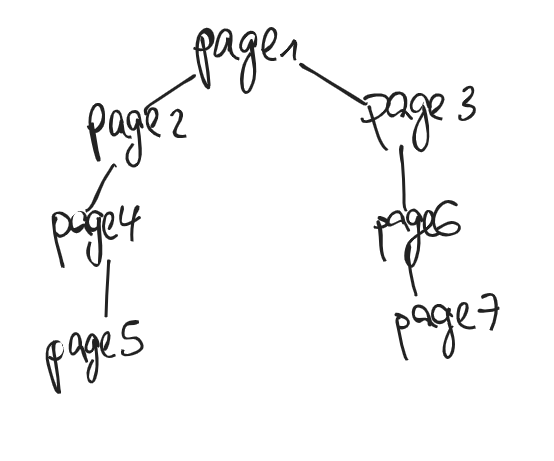

Then, if we call `get_pages_depth()` at `page_1` with `depth = 2`, then it should retrieve the pages `page_1`, `page_2`, `page_4`, `page_3` and `page_6`. We won't care about the order in which these pages are retrieved.

- Implement the function as a generator.

- Remember that a page might contain a link to a parent page, so try to take that into account.

- Consider any other edge cases that might happen, such as two pages leading to the same page. In that case, that page should only be retrieved once.

- Maybe you can add a decorator to handle such cases?

In [6]:
from bs4 import BeautifulSoup
import requests

def get_pages_depth(url: str, depth: int):
    """
    Go as deep as the given depth, through the links in the webpage at the given URL
    and yield the HTML content of each of them.

    :param url: A string that is the URL of the webpage
    :param depth: An integer that is the depth until which the function searches
    """
    seen_pages = set()

    def helper(current_url, current_depth):
        if current_depth > depth or current_url in seen_pages:
            return

        seen_pages.add(current_url)

        try:
            response = requests.get(current_url)
            response.raise_for_status()
            yield response.text

            soup = BeautifulSoup(response.text, 'html.parser')
            links = [a.get('href') for a in soup.find_all('a', href=True)]
            valid_links = [link for link in links if link.startswith('http')]

            for link in valid_links:
                yield from helper(link, current_depth + 1)

        except requests.exceptions.RequestException as e:
            pass

    yield from helper(url, 0)

In [7]:
pages = get_pages_depth(depth = 2, url = 'http://en.wikipedia.org')

In [8]:
next(pages)

'<!DOCTYPE html>\n<html class="client-nojs vector-feature-language-in-header-enabled vector-feature-language-in-main-page-header-disabled vector-feature-sticky-header-disabled vector-feature-page-tools-pinned-disabled vector-feature-toc-pinned-clientpref-1 vector-feature-main-menu-pinned-disabled vector-feature-limited-width-clientpref-1 vector-feature-limited-width-content-disabled vector-feature-custom-font-size-clientpref-1 vector-feature-appearance-pinned-clientpref-1 vector-feature-night-mode-enabled skin-theme-clientpref-day vector-toc-not-available" lang="en" dir="ltr">\n<head>\n<meta charset="UTF-8">\n<title>Wikipedia, the free encyclopedia</title>\n<script>(function(){var className="client-js vector-feature-language-in-header-enabled vector-feature-language-in-main-page-header-disabled vector-feature-sticky-header-disabled vector-feature-page-tools-pinned-disabled vector-feature-toc-pinned-clientpref-1 vector-feature-main-menu-pinned-disabled vector-feature-limited-width-clien

## Task 4

Create a class `ComputerScientist` that will contain information such as `name`, `birthdate`, `major_achievements`, `alma_mater`, etc.

- Implement the methods you consider appropriate.

- Make unit tests to make sure the methods work alright.

Write a script to go to this [list of computer scientists](https://en.wikipedia.org/wiki/List_of_computer_scientists) and fetch information about 100 random scientists from this list, and create a python `list` containing `ComputerScientist()` objects with the information retrieved from the given link.

In [9]:
from bs4 import BeautifulSoup
import requests
import random
import unittest

# ComputerScientist class
class ComputerScientist:
    def __init__(self, name, birthdate=None, major_achievements=None, alma_mater=None):
        self.name = name
        self.birthdate = birthdate
        self.major_achievements = major_achievements if major_achievements else []
        self.alma_mater = alma_mater

    def add_achievement(self, achievement):
        self.major_achievements.append(achievement)

    def __repr__(self):
        return f"ComputerScientist(name={self.name}, birthdate={self.birthdate}, " \
               f"major_achievements={self.major_achievements}, alma_mater={self.alma_mater})"

# Ut
class TestComputerScientist(unittest.TestCase):
    def test_initialization(self):
        cs = ComputerScientist("Alan Turing", "1912-06-23", ["Turing Machine", "Father of AI"], "University of Cambridge")
        self.assertEqual(cs.name, "Alan Turing")
        self.assertEqual(cs.birthdate, "1912-06-23")
        self.assertIn("Turing Machine", cs.major_achievements)
        self.assertEqual(cs.alma_mater, "University of Cambridge")

    def test_add_achievement(self):
        cs = ComputerScientist("Grace Hopper")
        cs.add_achievement("Developed the first compiler")
        self.assertIn("Developed the first compiler", cs.major_achievements)

# Scraping fun
def scrape_computer_scientists():
    url = "https://en.wikipedia.org/wiki/List_of_computer_scientists"
    response = requests.get(url)
    if response.status_code != 200:
        raise Exception("Failed to fetch the page")

    soup = BeautifulSoup(response.content, "html.parser")

    scientist_links = soup.select("li > a")
    scientists = []

    for link in scientist_links:
        if link.get("href") and link["href"].startswith("/wiki/"):
            scientists.append((link.text, f"https://en.wikipedia.org{link['href']}"))

    random_scientists = random.sample(scientists, min(100, len(scientists)))

    scientist_objects = []
    for name, link in random_scientists:
        try:
            scientist_page = requests.get(link)
            scientist_soup = BeautifulSoup(scientist_page.content, "html.parser")

            birthdate = None
            alma_mater = None
            major_achievements = []

            infobox = scientist_soup.find("table", class_="infobox")
            if infobox:
                birthdate_tag = infobox.find("span", class_="bday")
                if birthdate_tag:
                    birthdate = birthdate_tag.text

                alma_mater_row = infobox.find("th", string="Alma mater")
                if alma_mater_row:
                    alma_mater = alma_mater_row.find_next_sibling("td").text.strip()

            first_paragraph = scientist_soup.find("p")
            if first_paragraph:
                major_achievements.append(first_paragraph.text.strip())

            scientist = ComputerScientist(name, birthdate, major_achievements, alma_mater)
            scientist_objects.append(scientist)
        except Exception as e:
            print(f"Failed to process {name}: {e}")

    return scientist_objects

if __name__ == "__main__":
    unittest.main(argv=[''], exit=False)

    scientists = scrape_computer_scientists()
    for scientist in scientists:
        print(scientist)

....

Error fetching the initial URL: HTTPConnectionPool(host='this-is-not-valid', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x7f913a83da80>: Failed to resolve 'this-is-not-valid' ([Errno -2] Name or service not known)"))


.
----------------------------------------------------------------------
Ran 5 tests in 1.504s

OK


ComputerScientist(name=Walter F. Tichy, birthdate=1952-04-22, major_achievements=['Walter F. Tichy (born April 22, 1952, in Bad Reichenhall) is a German computer scientist. He was professor of computer science at the Karlsruhe Institute of Technology in Germany where he taught classes in software engineering until April 2022. He remains at KIT as a professor emeritus and has been teaching at Kutaisi International University in Georgia since September 2022.'], alma_mater=None)
ComputerScientist(name=John Ousterhout, birthdate=1954-10-15, major_achievements=['John Kenneth Ousterhout (/ˈoʊstərhaʊt/, born October 15, 1954) is an American computer scientist. He is a professor of computer science at Stanford University. He founded Electric Cloud with John Graham-Cumming.'], alma_mater=None)
ComputerScientist(name=Alexander Dewdney, birthdate=1941-08-05, major_achievements=['Alexander Keewatin Dewdney (August 5, 1941 – March 9, 2024) was a Canadian mathematician, computer scientist, author, f

In [10]:
if __name__ == "__main__":
    scientists = scrape_computer_scientists()

    # Ex: top 2 scientists in a structured format
    for scientist in scientists[:2]:
        print(f"Name: {scientist.name}")
        print(f"Birthdate: {scientist.birthdate or 'N/A'}")
        print(f"Major Achievements: {', '.join(scientist.major_achievements) or 'N/A'}")
        print(f"Alma Mater: {scientist.alma_mater or 'N/A'}")
        print("-" * 50)

Name: IFIP WG 2.1
Birthdate: N/A
Major Achievements: IFIP Working Group 2.1 on Algorithmic Languages and Calculi is a working group of the International Federation for Information Processing (IFIP).
Alma Mater: N/A
--------------------------------------------------
Name: model checking
Birthdate: N/A
Major Achievements: In computer science, model checking or property checking is a method for checking whether a finite-state model of a system meets a given specification (also known as correctness). This is typically associated with hardware or software systems, where the specification contains liveness requirements (such as avoidance of livelock) as well as safety requirements (such as avoidance of states representing a system crash).
Alma Mater: N/A
--------------------------------------------------


# Task 5

Use the previously defined `ComputerScientist` class.

Add a new attribute `wikipedia_link` without modifying the definition of the original class. Consider using `setattr()`.

Write a function `fetch_scientist()` that will receive the name of a scientist, and will go to wikipedia and fetch the required scientist, and return a `ComputerScientist` object.

- Remember checking edge cases, such as the scientist not existing.

Add a decorator to cache the request, (i.e: store the answers, and if the scientist was already found before, to not execute the search again).

In [11]:
from bs4 import BeautifulSoup
import requests
from functools import lru_cache

class ComputerScientist:
    def __init__(self, name, birthdate=None, major_achievements=None, alma_mater=None):
        self.name = name
        self.birthdate = birthdate
        self.major_achievements = major_achievements if major_achievements else []
        self.alma_mater = alma_mater

    def add_achievement(self, achievement):
        self.major_achievements.append(achievement)

    def __repr__(self):
        return f"ComputerScientist(name={self.name}, birthdate={self.birthdate}, " \
               f"major_achievements={self.major_achievements}, alma_mater={self.alma_mater})"

def add_wikipedia_link(scientist_obj, link):
    setattr(scientist_obj, 'wikipedia_link', link)

@lru_cache(maxsize=50)
def fetch_scientist(scientist_name):
    """
    Fetch the scientist's details from Wikipedia and return a ComputerScientist object.
    """
    url = f"https://en.wikipedia.org/wiki/{scientist_name.replace(' ', '_')}"
    response = requests.get(url)

    if response.status_code != 200:
        raise Exception(f"Scientist '{scientist_name}' not found on Wikipedia.")

    soup = BeautifulSoup(response.content, "html.parser")

    birthdate = None
    alma_mater = None
    major_achievements = []

    infobox = soup.find("table", class_="infobox")
    if infobox:
        birthdate_tag = infobox.find("span", class_="bday")
        if birthdate_tag:
            birthdate = birthdate_tag.text

        alma_mater_row = infobox.find("th", string="Alma mater")
        if alma_mater_row:
            alma_mater = alma_mater_row.find_next_sibling("td").text.strip()

    first_paragraph = soup.find("p")
    if first_paragraph:
        major_achievements.append(first_paragraph.text.strip())

    scientist = ComputerScientist(scientist_name, birthdate, major_achievements, alma_mater)

    add_wikipedia_link(scientist, url)

    return scientist

# Example
if __name__ == "__main__":
    try:
        scientist = fetch_scientist("Alan Turing")
        print(scientist)
        print(f"Wikipedia Link: {scientist.wikipedia_link}")

        scientist2 = fetch_scientist("Grace Hopper")
        print(scientist2)
        print(f"Wikipedia Link: {scientist2.wikipedia_link}")
    except Exception as e:
        print(e)

ComputerScientist(name=Alan Turing, birthdate=1912-06-23, major_achievements=[''], alma_mater=None)
Wikipedia Link: https://en.wikipedia.org/wiki/Alan_Turing
ComputerScientist(name=Grace Hopper, birthdate=1906-12-09, major_achievements=[''], alma_mater=None)
Wikipedia Link: https://en.wikipedia.org/wiki/Grace_Hopper


# Task 6**

Consider the directed graph where the nodes represent the wikipedia pages of the scientists and the edges represent whether a scientist's page contains a link to the page of another scientist.

Implement a class named `ScientistGraph`, with some attributes and methods like:
- `scientist_list : list[ComputerScientist]`: the list of all scientists
- `graph`: the graph of scientists connected to other scientists (you can use the graph object from `network`, or implement your own way of storing the graph, for e.g: with an adjacency list or an adjacency matrix).
- `add_scientist(scientist_name: str)`: method that will receive the name of the scientist, fetch the corresponding wikipedia page, create the corresponding `ComputerScientist` object, and will add the new edges involving that scientist to the graph. Consider edge cases like the name being incorrect or the scientist being already stored.
- `remove_scientist(scientist_name: str)`: method that will receive the name of a scientist, remove them from the list and removing its node and the edges involving it from the graph. Consider edge cases like the name being incorrect or the scientist not being stored.
- `plot()`: method that will visualize the graph. Show how the graph changes when adding someone new or deleting someone. Bonus: perhaps you want to implement it in a dynamic way, so each time that a scientist is removed from or added to the graph, the visualization changes.
- `rank_scientists():` method that will rank scientists. For this method you can be as creative as you wish: You can start by designing a ranking based on the number of neighbours of each scientists, or the number of times a scientist is mentioned in one of the articles, or by using the famous `PageRank (you need to google it)`, etc., or by any other methods you might like to consider.

Show the usage of these methods in a proper way.
Feel free to add more functionalities.

Added Alan Turing to the graph.
Grace Hopper is already in the graph.
John von Neumann is already in the graph.


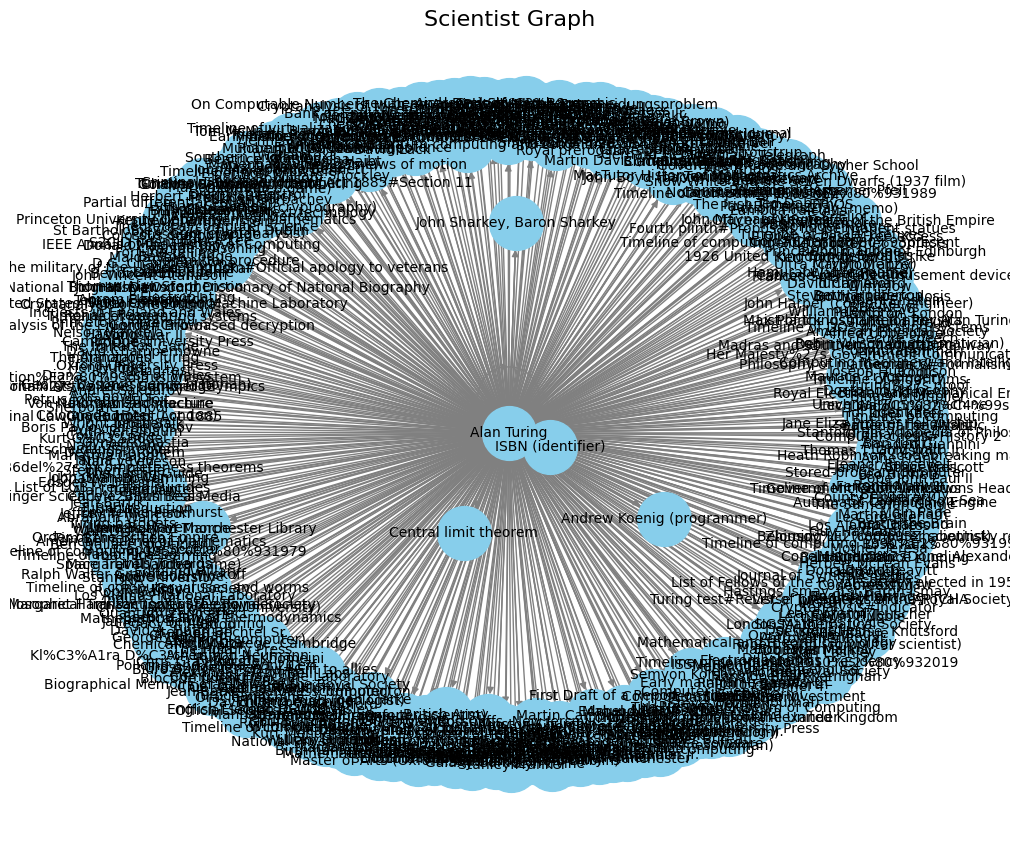

Scientist Rankings (based on PageRank):
1. Alan Turing: 0.0016
2. Main Page: 0.0016
3. Turing (disambiguation): 0.0016
4. Officer of the Order of the British Empire: 0.0016
5. Fellow of the Royal Society: 0.0016
6. Maida Vale: 0.0016
7. Wilmslow: 0.0016
8. Cyanide poisoning: 0.0016
9. Suicide: 0.0016
10. University of Cambridge: 0.0016
11. Bachelor of Arts: 0.0016
12. Master of Arts (Oxford, Cambridge, and Dublin): 0.0016
13. Princeton University: 0.0016
14. Doctor of Philosophy: 0.0016
15. Cryptanalysis of the Enigma: 0.0016
16. Turing%27s proof: 0.0016
17. Turing machine: 0.0016
18. Turing test: 0.0016
19. Unorganized machine: 0.0016
20. Turing pattern: 0.0016
21. Turing reduction: 0.0016
22. The Chemical Basis of Morphogenesis: 0.0016
23. Quantum Zeno effect: 0.0016
24. Smith%27s Prize: 0.0016
25. Logic: 0.0016
26. Mathematics: 0.0016
27. Cryptanalysis: 0.0016
28. Computer science: 0.0016
29. Mathematical and theoretical biology: 0.0016
30. Victoria University of Manchester: 0.0016


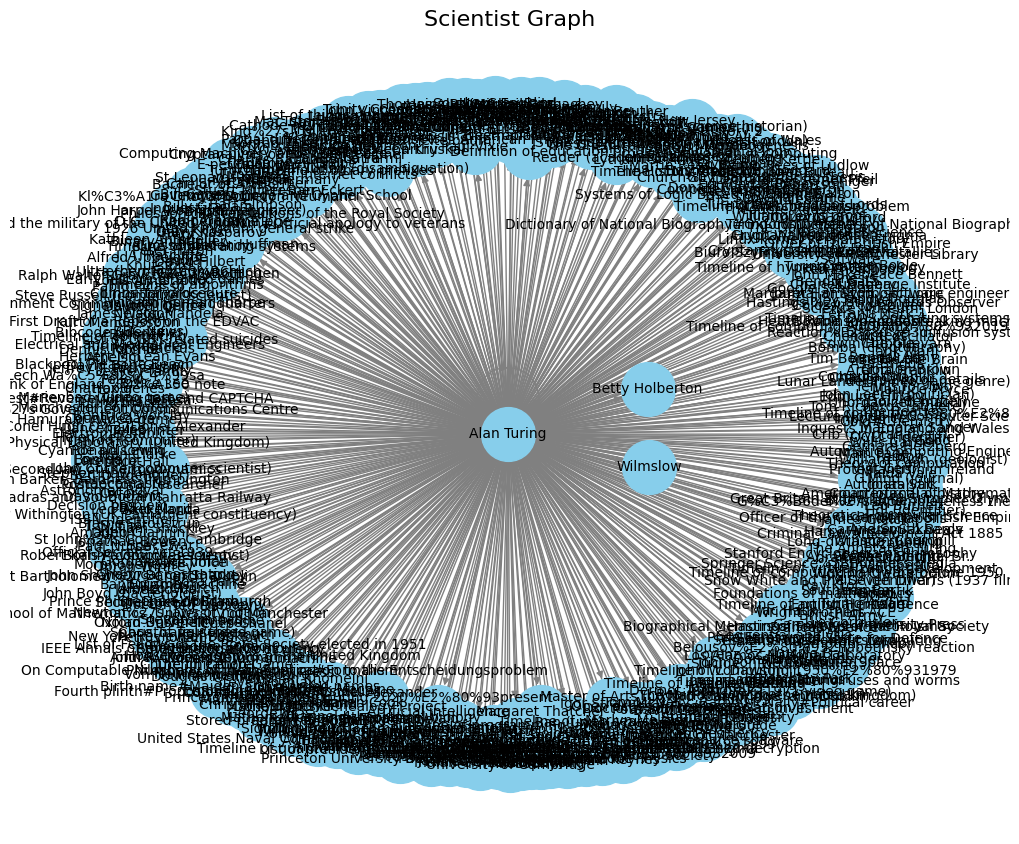

Scientist Rankings (based on PageRank):
1. Alan Turing: 0.0016
2. Main Page: 0.0016
3. Turing (disambiguation): 0.0016
4. Officer of the Order of the British Empire: 0.0016
5. Fellow of the Royal Society: 0.0016
6. Maida Vale: 0.0016
7. Wilmslow: 0.0016
8. Cyanide poisoning: 0.0016
9. Suicide: 0.0016
10. University of Cambridge: 0.0016
11. Bachelor of Arts: 0.0016
12. Master of Arts (Oxford, Cambridge, and Dublin): 0.0016
13. Princeton University: 0.0016
14. Doctor of Philosophy: 0.0016
15. Cryptanalysis of the Enigma: 0.0016
16. Turing%27s proof: 0.0016
17. Turing machine: 0.0016
18. Turing test: 0.0016
19. Unorganized machine: 0.0016
20. Turing pattern: 0.0016
21. Turing reduction: 0.0016
22. The Chemical Basis of Morphogenesis: 0.0016
23. Quantum Zeno effect: 0.0016
24. Smith%27s Prize: 0.0016
25. Logic: 0.0016
26. Mathematics: 0.0016
27. Cryptanalysis: 0.0016
28. Computer science: 0.0016
29. Mathematical and theoretical biology: 0.0016
30. Victoria University of Manchester: 0.0016


In [12]:
import networkx as nx
import matplotlib.pyplot as plt
from functools import lru_cache
from bs4 import BeautifulSoup
import requests

class ComputerScientist:
    def __init__(self, name, birthdate=None, major_achievements=None, alma_mater=None):
        self.name = name
        self.birthdate = birthdate
        self.major_achievements = major_achievements if major_achievements else []
        self.alma_mater = alma_mater

    def add_achievement(self, achievement):
        self.major_achievements.append(achievement)

    def __repr__(self):
        return f"ComputerScientist(name={self.name}, birthdate={self.birthdate}, " \
               f"major_achievements={self.major_achievements}, alma_mater={self.alma_mater})"

class ScientistGraph:
    def __init__(self):
        self.scientist_list = []
        self.graph = nx.DiGraph()

    @lru_cache(maxsize=None)
    def fetch_scientist(self, scientist_name: str) -> ComputerScientist:
        """Fetch details of a scientist and return a ComputerScientist object."""
        base_url = "https://en.wikipedia.org/wiki/"
        url = base_url + scientist_name.replace(" ", "_")
        response = requests.get(url)

        if response.status_code != 200:
            raise ValueError(f"Could not fetch page for scientist: {scientist_name}")

        soup = BeautifulSoup(response.content, "html.parser")
        birthdate = None
        alma_mater = None
        major_achievements = []

        infobox = soup.find("table", class_="infobox")
        if infobox:
            birthdate_tag = infobox.find("span", class_="bday")
            if birthdate_tag:
                birthdate = birthdate_tag.text

            alma_mater_row = infobox.find("th", string="Alma mater")
            if alma_mater_row:
                alma_mater = alma_mater_row.find_next_sibling("td").text.strip()

        first_paragraph = soup.find("p")
        if first_paragraph:
            major_achievements.append(first_paragraph.text.strip())

        scientist = ComputerScientist(scientist_name, birthdate, major_achievements, alma_mater)
        setattr(scientist, "wikipedia_link", url)

        links = soup.find_all("a", href=True)
        for link in links:
            href = link["href"]
            if href.startswith("/wiki/") and ":" not in href:
                linked_scientist = href.split("/wiki/")[1].replace("_", " ")
                self.graph.add_edge(scientist_name, linked_scientist)

        return scientist

    def add_scientist(self, scientist_name: str):
        """Add a scientist to the graph."""
        if scientist_name in self.graph.nodes:
            print(f"{scientist_name} is already in the graph.")
            return

        try:
            scientist = self.fetch_scientist(scientist_name)
            self.scientist_list.append(scientist)
            self.graph.add_node(scientist_name)
            print(f"Added {scientist_name} to the graph.")
        except ValueError as e:
            print(e)

    def remove_scientist(self, scientist_name: str):
        """Remove a scientist from the graph."""
        if scientist_name not in self.graph.nodes:
            print(f"{scientist_name} is not in the graph.")
            return

        self.graph.remove_node(scientist_name)
        self.scientist_list = [s for s in self.scientist_list if s.name != scientist_name]
        print(f"Removed {scientist_name} from the graph.")

    def plot(self):
        """Visualize the graph."""
        plt.figure(figsize=(10, 8))
        pos = nx.spring_layout(self.graph)
        nx.draw(self.graph, pos, with_labels=True, node_color="skyblue", edge_color="gray", node_size=1500, font_size=10)
        plt.title("Scientist Graph", fontsize=16)
        plt.show()

    def rank_scientists(self):
        """Rank scientists based on PageRank."""
        page_rank = nx.pagerank(self.graph)
        ranked_scientists = sorted(page_rank.items(), key=lambda x: x[1], reverse=True)
        print("Scientist Rankings (based on PageRank):")
        for rank, (scientist, score) in enumerate(ranked_scientists, start=1):
            print(f"{rank}. {scientist}: {score:.4f}")

# Example
if __name__ == "__main__":
    sg = ScientistGraph()
    sg.add_scientist("Alan Turing")
    sg.add_scientist("Grace Hopper")
    sg.add_scientist("John von Neumann")
    sg.plot()
    sg.rank_scientists()
    sg.remove_scientist("Grace Hopper")
    sg.plot()
    sg.rank_scientists()